In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from sklearn.metrics import confusion_matrix
import seaborn as sns

import json
import os

import sys
from iterativenn.iterativenn.src.iterativenn import utils
from iterativenn.iterativenn.src.iterativenn.nn_modules.MaskedLinear import MaskedLinear

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train = pd.read_feather('/home/kjmetzler/train_data_subset.feather')
testing = pd.read_feather('/home/kjmetzler/test_data_subset.feather')

# Use the new combined synthetic data file
train_data_universal = pd.read_csv('/home/kjmetzler/Steve_generated_U_chemicals_06252025.csv')

label_list = ["DEB",  "DEM",  "DMMP",  "DPM",  "DtBP",  "JP8",  "MES",  "TEPO"]
label_size = label_list.__len__()

# Clean up the real data
testing = testing.drop('Unnamed: 0', axis=1)
testing = testing.drop("index", axis=1)
testing = testing.drop('Label', axis=1)

train = train.drop('Unnamed: 0', axis=1)
train = train.drop("index", axis=1)
train = train.drop('Label', axis=1)

# The synthetic data should already be processed with one-hot encoding
print(f"Synthetic data shape: {train_data_universal.shape}")
print(f"Synthetic data columns (last 10): {list(train_data_universal.columns)[-10:]}")

# Check chemical distribution in synthetic data
print("Chemical distribution in synthetic data:")
for label in label_list:
    if label in train_data_universal.columns:
        count = train_data_universal[label].sum()
        print(f"  {label}: {count}")
    else:
        print(f"  {label}: MISSING")

# Use the processed synthetic data directly
train_data = train_data_universal.copy()
#print(train_data_universal['Label'].value_counts())
del train_data_universal

print(f"Final training data shape: {train_data.shape}")
print(f"Real data shape: {train.shape}")
print(f"Test data shape: {testing.shape}")

Synthetic data shape: (4000, 1677)
Synthetic data columns (last 10): ['n_1013', 'n_1014', 'n_1015', 'n_1016', 'n_1017', 'n_1018', 'n_1019', 'n_1020', 'n_1021', 'Label_U']
Chemical distribution in synthetic data:
  DEB: MISSING
  DEM: MISSING
  DMMP: MISSING
  DPM: MISSING
  DtBP: MISSING
  JP8: MISSING
  MES: MISSING
  TEPO: MISSING
Final training data shape: (4000, 1677)
Real data shape: (8000, 1684)
Test data shape: (8000, 1684)


In [4]:
print(train_data['Label_U'].value_counts())

DEB     500
DEM     500
DMMP    500
DPM     500
DtBP    500
JP8     500
MES     500
TEPO    500
Name: Label_U, dtype: int64


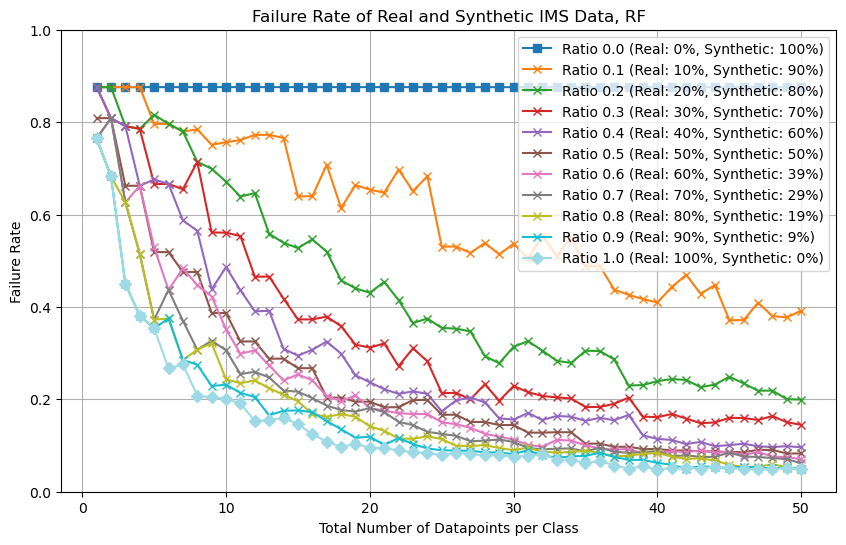

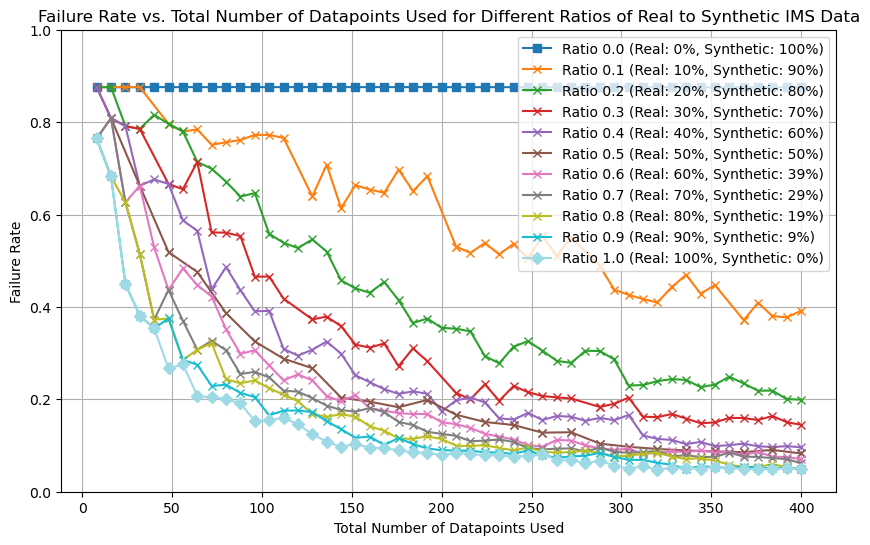

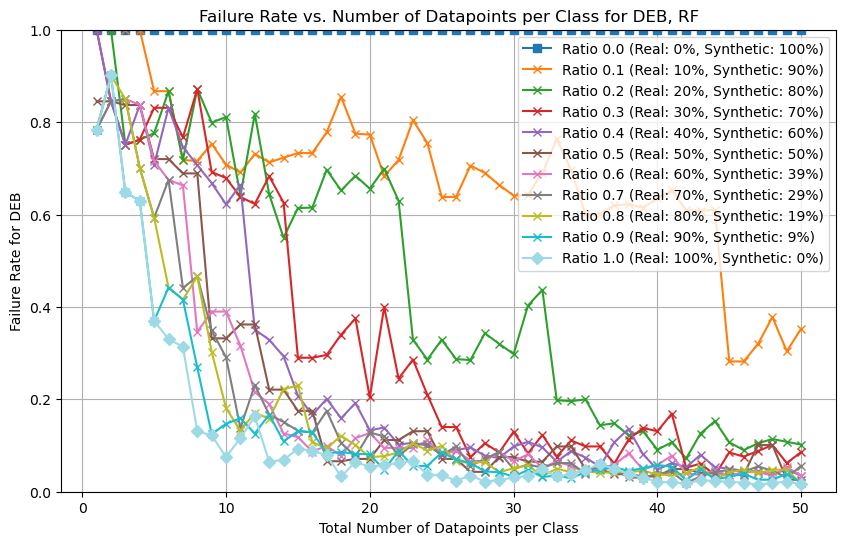

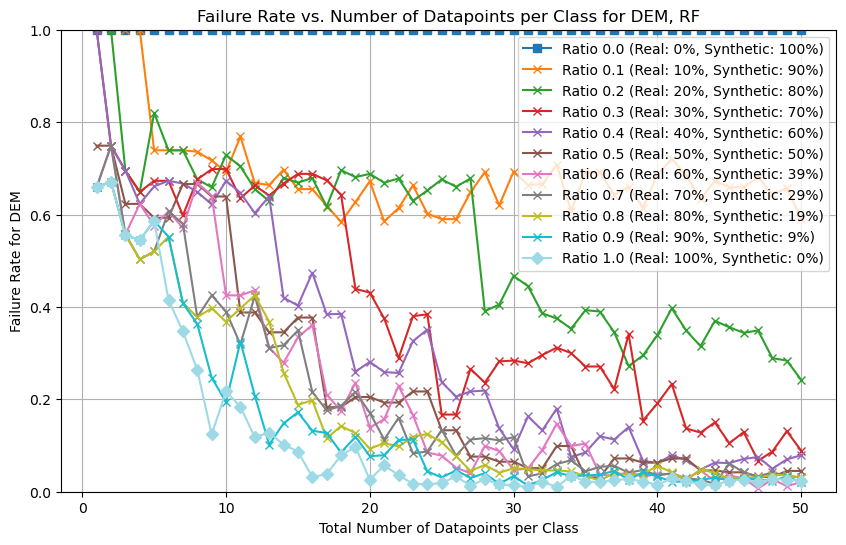

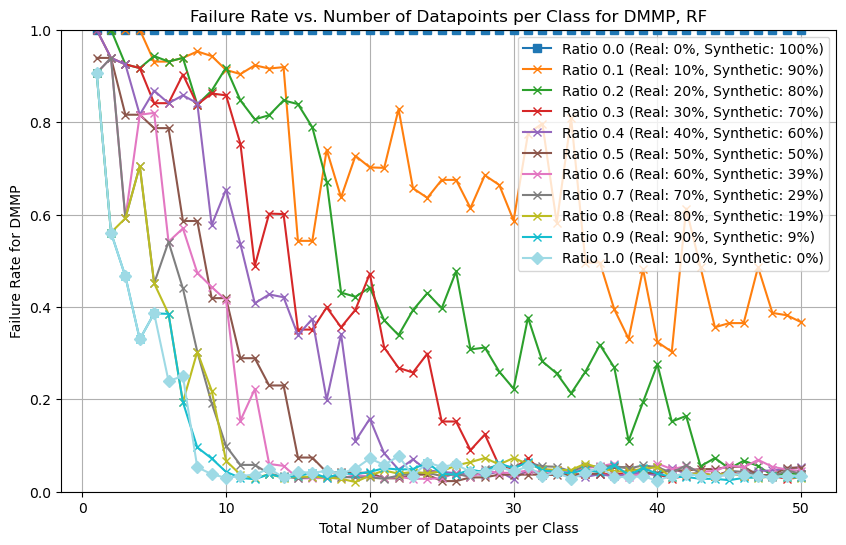

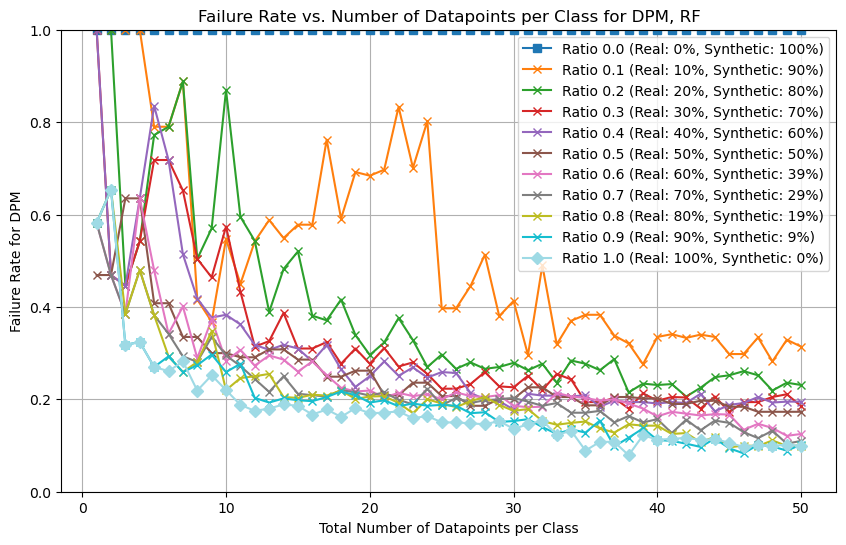

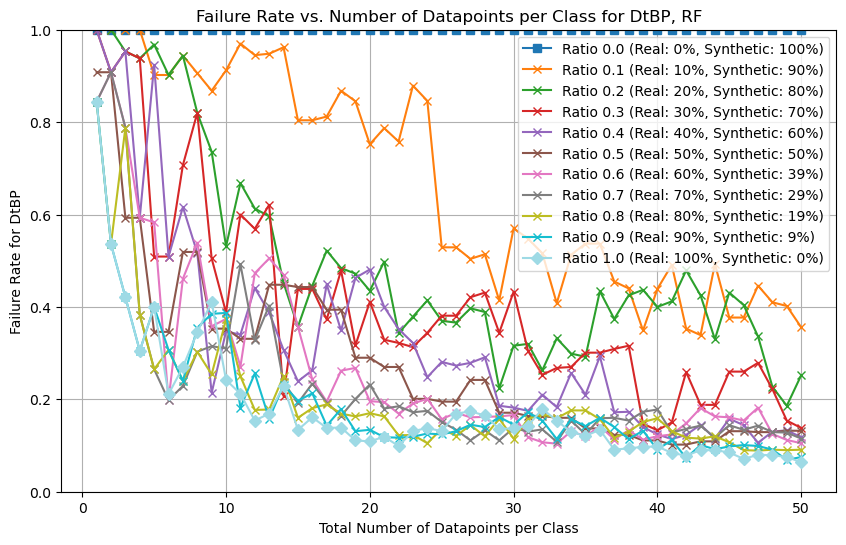

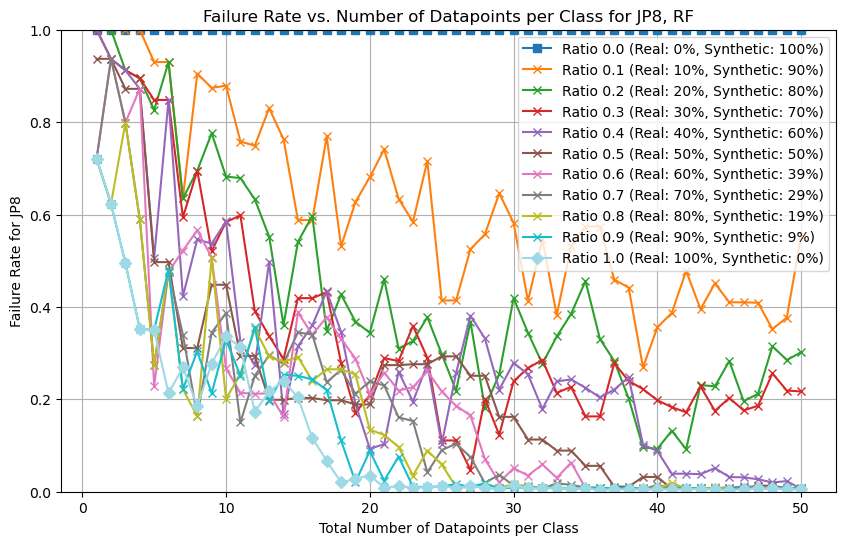

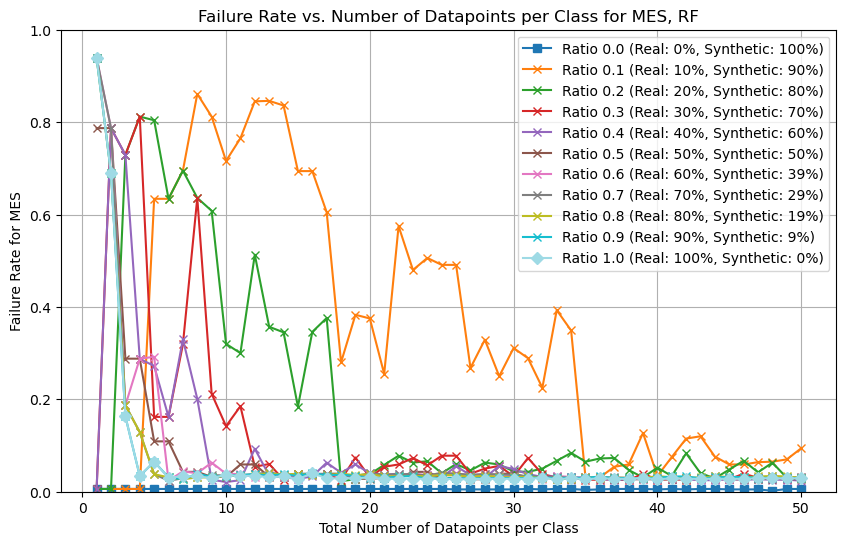

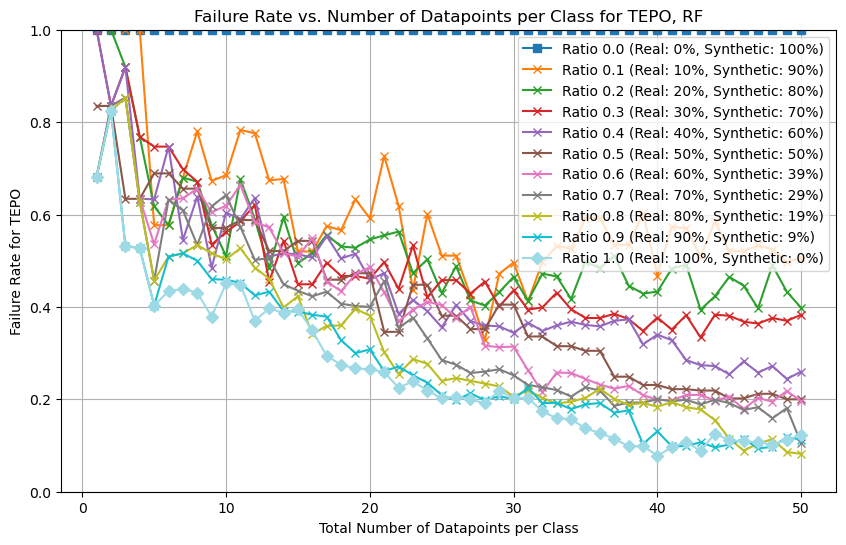

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import random

# Function to train and evaluate the random forest classifier
def train_and_evaluate_rf(X_train, y_train, X_test, y_test):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy, y_pred

# Function to run the tests with different numbers of datapoints per class and ratios of real to synthetic data
def run_tests(real_data, synthetic_data, test_data, num_points_per_class, ratios):
    index = 0#random.randint(0, 1000)

    X_real, y_real = real_data.iloc[:, :-label_size].values, np.argmax(real_data.iloc[:, -label_size:].values, axis=1)
    X_synthetic, y_synthetic = synthetic_data.iloc[:, :-label_size].values, np.argmax(synthetic_data.iloc[:, -label_size:].values, axis=1)
    X_test, y_test = test_data.iloc[:, :-label_size].values, np.argmax(test_data.iloc[:, -label_size:].values, axis=1)
    
    results = []
    class_results = {class_label: [] for class_label in range(len(np.unique(y_test)))}
    
    for ratio in ratios:
        for num_points in num_points_per_class:
            X_train = []
            y_train = []
            
            for class_label in np.unique(y_real):
                real_indices = np.where(y_real == class_label)[0][index:int(num_points * ratio + 0.5)+index]
                synthetic_indices = np.where(y_synthetic == class_label)[0][index:int(num_points * (1 - ratio) + 0.5)+index]
                
                if len(real_indices) > 0:
                    X_train.append(X_real[real_indices])
                    y_train.append(y_real[real_indices])
                if len(synthetic_indices) > 0:    
                    X_train.append(X_synthetic[synthetic_indices])
                    y_train.append(y_synthetic[synthetic_indices])
            
            if len(X_train) > 0 and len(y_train) > 0:
                X_train = np.vstack(X_train)
                y_train = np.hstack(y_train)
                
                accuracy, y_pred = train_and_evaluate_rf(X_train, y_train, X_test, y_test)
                results.append((num_points, ratio, accuracy, len(X_train)))
                
                class_accuracies = class_wise_accuracy(y_test, y_pred, len(np.unique(y_test)))
                for class_label in range(len(np.unique(y_test))):
                    class_results[class_label].append((num_points, ratio, class_accuracies[class_label]))
    
    return results, class_results

# Function to calculate class-wise accuracy
def class_wise_accuracy(y_true, y_pred, num_classes):
    accuracies = []
    for class_label in range(num_classes):
        class_indices = np.where(y_true == class_label)[0]
        class_accuracy = accuracy_score(y_true[class_indices], y_pred[class_indices])
        accuracies.append(class_accuracy)
    return accuracies

# Define the number of datapoints per class to test and the ratios of real to synthetic data
num_points_per_class = np.arange(1, 51)  # 1 to 50
ratios = np.linspace(0, 1, 11)  # Ratios from 0 to 1 in steps of 0.1

# Run the tests
label_size = 8  # Assuming there are 8 label columns at the end of the dataframe
results, class_results = run_tests(train, train_data, testing, num_points_per_class, ratios)

# Extract the results
num_points, ratios, accuracies, num_datapoints = zip(*results)

#'''
# Plot the overall accuracy results
plt.figure(figsize=(10, 6))
colors = plt.cm.tab20(np.linspace(0, 1, len(np.unique(ratios))))
shapes = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'x', 'd', '|', '_', '+', '1', '2', '3', '4']
for i, ratio in enumerate(np.unique(ratios)):
    mask = np.array(ratios) == ratio
    shape = 'x' if ratio not in [0, 1] else ('s' if ratio == 0 else 'D')
    plt.plot(np.array(num_points)[mask], 1 - np.array(accuracies)[mask], marker=shape, label=f'Ratio {ratio:.1f} (Real: {int(ratio*100)}%, Synthetic: {int((1-ratio)*100)}%)', color=colors[i])
plt.xlabel('Total Number of Datapoints per Class')
plt.ylabel('Failure Rate')
plt.title('Failure Rate of Real and Synthetic IMS Data, RF')
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(10, 6))
for i, ratio in enumerate(np.unique(ratios)):
    mask = np.array(ratios) == ratio
    shape = 'x' if ratio not in [0, 1] else ('s' if ratio == 0 else 'D')
    plt.plot(np.array(num_datapoints)[mask], 1 - np.array(accuracies)[mask], marker=shape, label=f'Ratio {ratio:.1f} (Real: {int(ratio*100)}%, Synthetic: {int((1-ratio)*100)}%)', color=colors[i])
plt.xlabel('Total Number of Datapoints Used')
plt.ylabel('Failure Rate')
plt.title('Failure Rate vs. Total Number of Datapoints Used for Different Ratios of Real to Synthetic IMS Data')
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.show()

# Plot class-wise accuracies
for class_label in range(label_size):
    plt.figure(figsize=(10, 6))
    for i, ratio in enumerate(np.unique(ratios)):
        mask = np.array([result[1] for result in class_results[class_label]]) == ratio
        shape = 'x' if ratio not in [0, 1] else ('s' if ratio == 0 else 'D')
        plt.plot(np.array([result[0] for result in class_results[class_label]])[mask], 
                 1 - np.array([result[2] for result in class_results[class_label]])[mask], 
                 marker=shape, label=f'Ratio {ratio:.1f} (Real: {int(ratio*100)}%, Synthetic: {int((1-ratio)*100)}%)', color=colors[i])
    plt.xlabel('Total Number of Datapoints per Class')
    plt.ylabel(f'Failure Rate for {label_list[class_label]}')
    plt.title(f'Failure Rate vs. Number of Datapoints per Class for {label_list[class_label]}, RF')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.show()
#'''


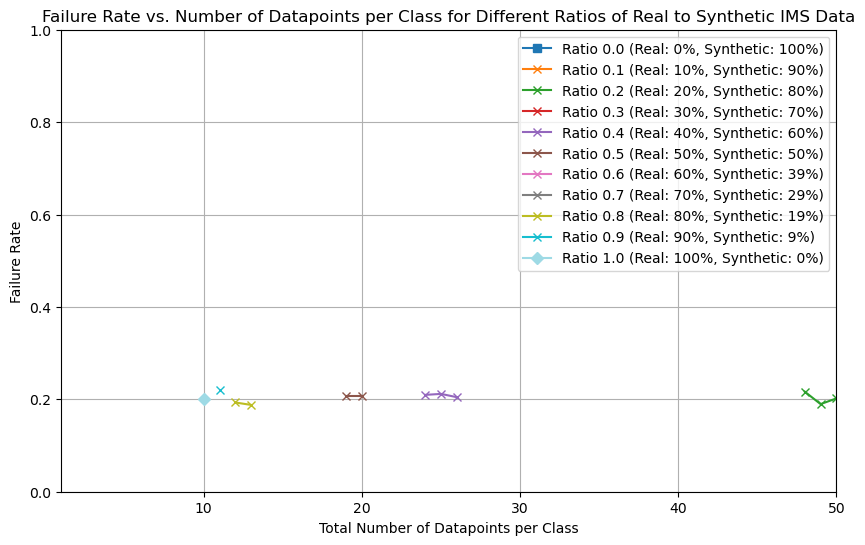

Overall Accuracy Data:
    Num Points  Failure Rate  Ratio
0           48      0.216625    0.2
1           49      0.189625    0.2
2           50      0.202000    0.2
3           24      0.209625    0.4
4           25      0.211750    0.4
5           26      0.204625    0.4
6           19      0.208125    0.5
7           20      0.208125    0.5
8           12      0.193125    0.8
9           13      0.187875    0.8
10          11      0.219125    0.9
11          10      0.200875    1.0


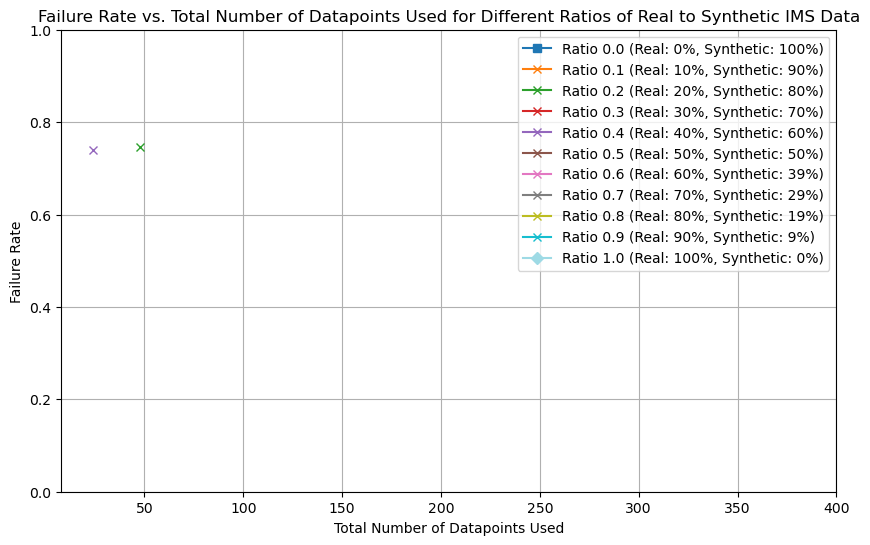

Datapoints Accuracy Data:
   Num Datapoints  Failure Rate  Ratio
0              48      0.745875    0.2
1              24      0.738875    0.4


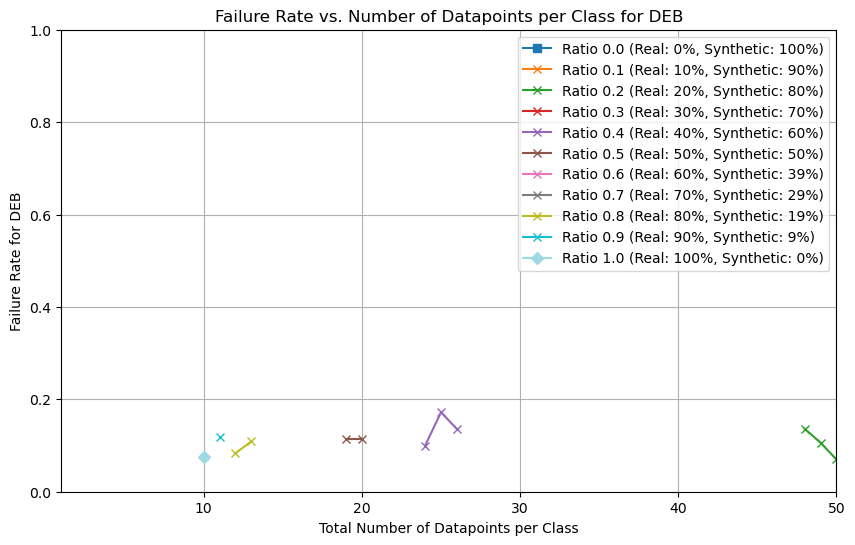

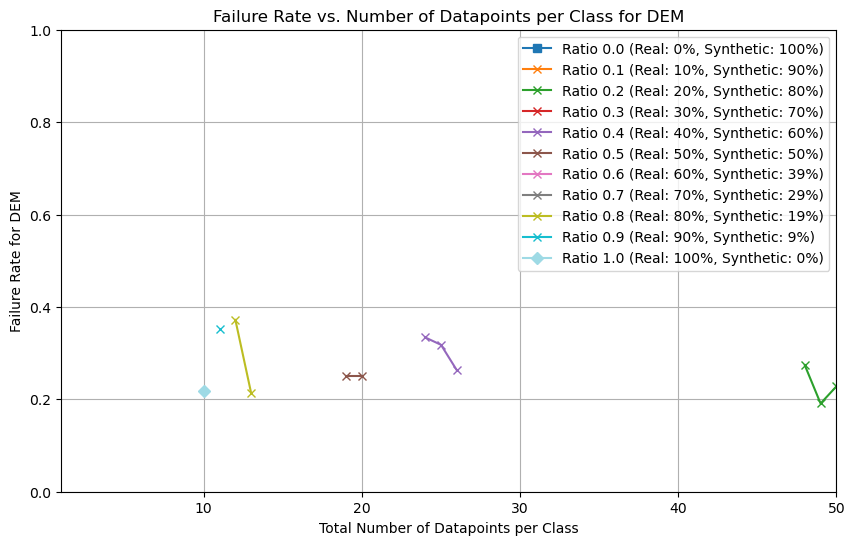

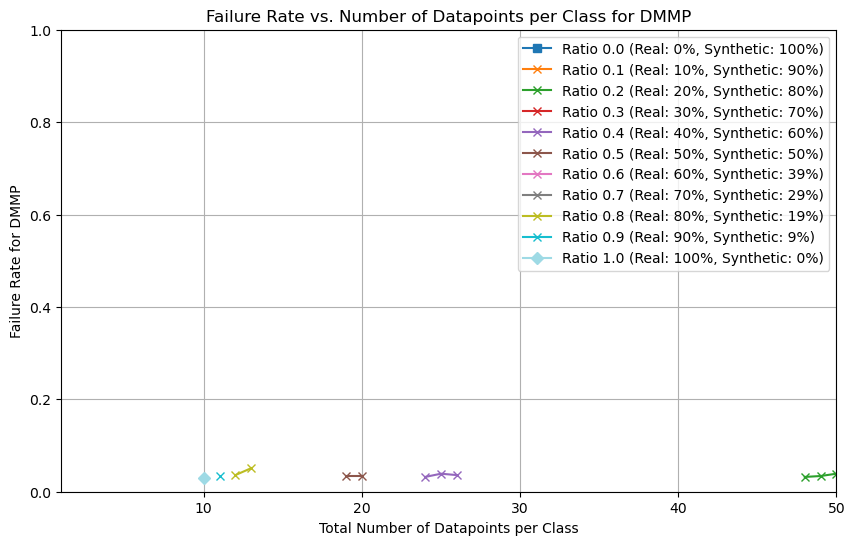

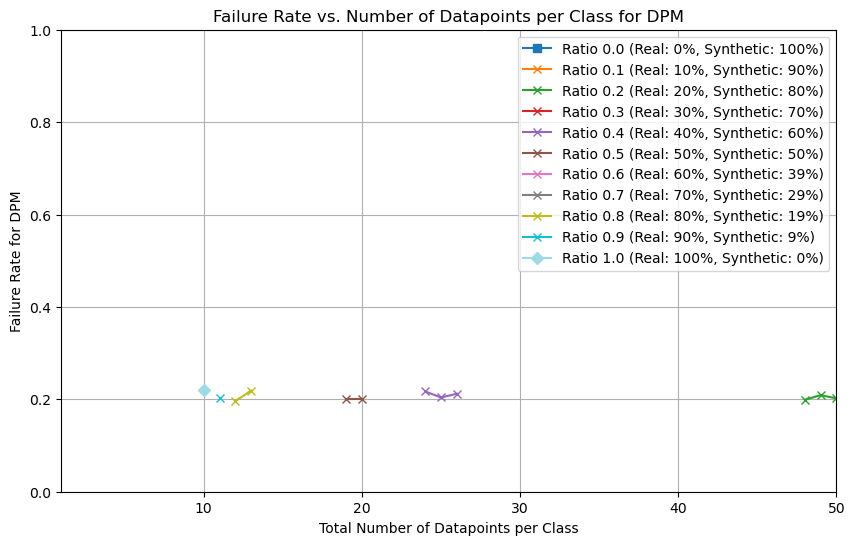

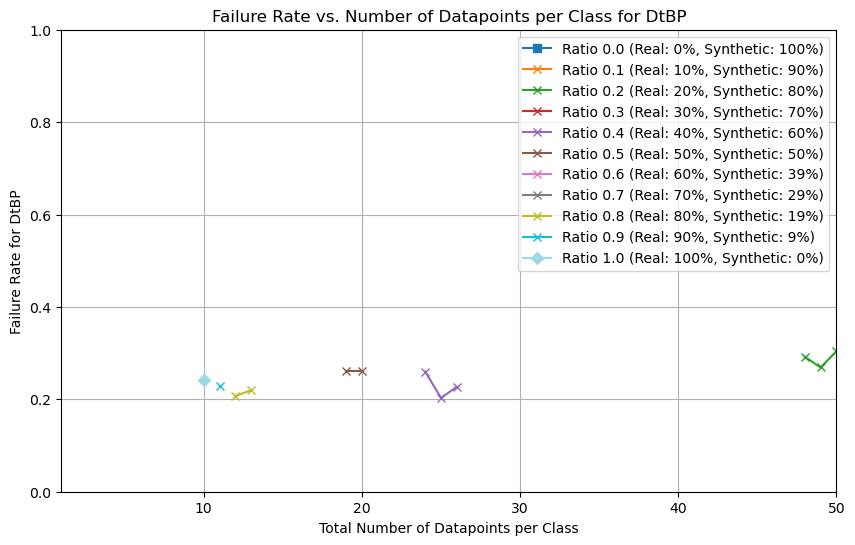

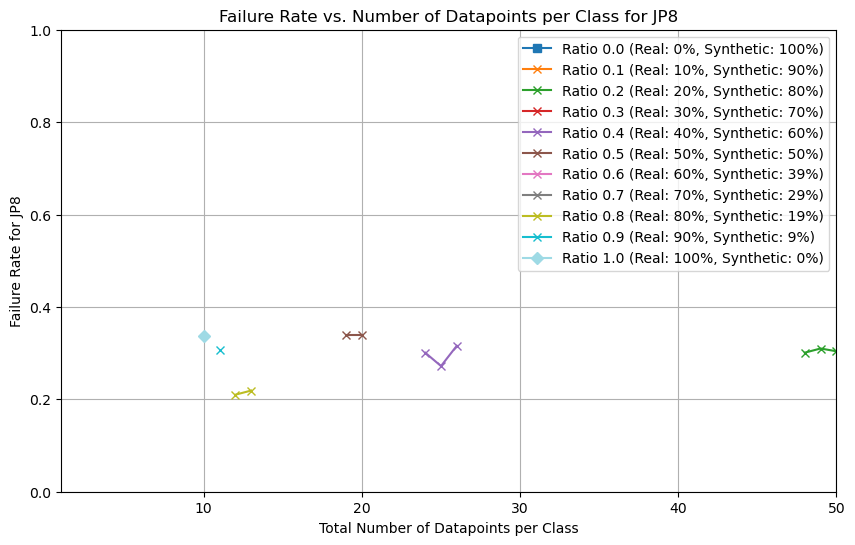

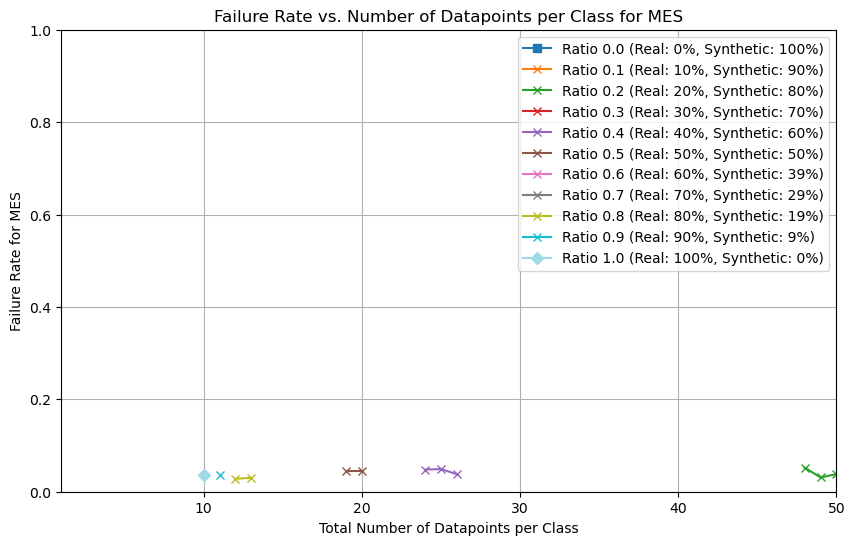

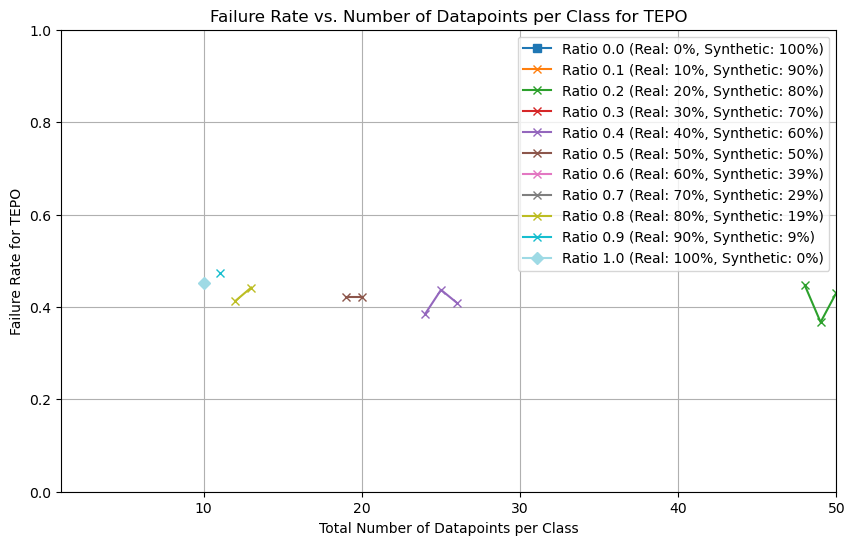

Class-wise Accuracy Data:
    Num Points  Failure Rate  Ratio Class
0           48         0.136    0.2   DEB
1           49         0.106    0.2   DEB
2           50         0.070    0.2   DEB
3           24         0.100    0.4   DEB
4           25         0.172    0.4   DEB
5           26         0.136    0.4   DEB
6           19         0.114    0.5   DEB
7           20         0.114    0.5   DEB
8           12         0.083    0.8   DEB
9           13         0.109    0.8   DEB
10          11         0.119    0.9   DEB
11          10         0.075    1.0   DEB
12          48         0.274    0.2   DEM
13          49         0.191    0.2   DEM
14          50         0.228    0.2   DEM
15          24         0.334    0.4   DEM
16          25         0.318    0.4   DEM
17          26         0.263    0.4   DEM
18          19         0.250    0.5   DEM
19          20         0.250    0.5   DEM
20          12         0.372    0.8   DEM
21          13         0.213    0.8   DEM
22      

In [20]:
import pandas as pd

# Define the specific points to plot
specific_points = {
    1.0: [10],
    0.9: [11],
    0.8: [12, 13],
    0.7: [14],
    0.6: [16, 17],
    0.5: [19, 20],
    0.4: [24, 25, 26],
    0.3: [32, 33, 34],
    0.2: [48, 49, 50]
}

# Plot the overall accuracy results
plt.figure(figsize=(10, 6))
colors = plt.cm.tab20(np.linspace(0, 1, len(np.unique(ratios))))
shapes = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'x', 'd', '|', '_', '+', '1', '2', '3', '4']
overall_data = []

for i, ratio in enumerate(np.unique(ratios)):
    mask = np.array(ratios) == ratio
    specific_mask = np.isin(np.array(num_points)[mask], specific_points.get(ratio, []))
    shape = 'x' if ratio not in [0, 1] else ('s' if ratio == 0 else 'D')
    plt.plot(np.array(num_points)[mask][specific_mask], 1 - np.array(accuracies)[mask][specific_mask], marker=shape, label=f'Ratio {ratio:.1f} (Real: {int(ratio*100)}%, Synthetic: {int((1-ratio)*100)}%)', color=colors[i])
    overall_data.append(pd.DataFrame({
        'Num Points': np.array(num_points)[mask][specific_mask],
        'Failure Rate': 1 - np.array(accuracies)[mask][specific_mask],
        'Ratio': ratio
    }))

plt.xlabel('Total Number of Datapoints per Class')
plt.ylabel('Failure Rate')
plt.title('Failure Rate vs. Number of Datapoints per Class for Different Ratios of Real to Synthetic IMS Data')
plt.legend()
plt.grid(True)
plt.xlim(min(num_points), max(num_points))
plt.ylim(0, 1)
plt.show()

# Combine overall data into a single DataFrame and display
overall_df = pd.concat(overall_data, ignore_index=True)
print("Overall Accuracy Data:")
print(overall_df)

plt.figure(figsize=(10, 6))
datapoints_data = []

for i, ratio in enumerate(np.unique(ratios)):
    mask = np.array(ratios) == ratio
    specific_mask = np.isin(np.array(num_datapoints)[mask], specific_points.get(ratio, []))
    shape = 'x' if ratio not in [0, 1] else ('s' if ratio == 0 else 'D')
    plt.plot(np.array(num_datapoints)[mask][specific_mask], 1 - np.array(accuracies)[mask][specific_mask], marker=shape, label=f'Ratio {ratio:.1f} (Real: {int(ratio*100)}%, Synthetic: {int((1-ratio)*100)}%)', color=colors[i])
    datapoints_data.append(pd.DataFrame({
        'Num Datapoints': np.array(num_datapoints)[mask][specific_mask],
        'Failure Rate': 1 - np.array(accuracies)[mask][specific_mask],
        'Ratio': ratio
    }))

plt.xlabel('Total Number of Datapoints Used')
plt.ylabel('Failure Rate')
plt.title('Failure Rate vs. Total Number of Datapoints Used for Different Ratios of Real to Synthetic IMS Data')
plt.legend()
plt.grid(True)
plt.xlim(min(num_datapoints), max(num_datapoints))
plt.ylim(0, 1)
plt.show()

# Combine datapoints data into a single DataFrame and display
datapoints_df = pd.concat(datapoints_data, ignore_index=True)
print("Datapoints Accuracy Data:")
print(datapoints_df)

# Plot class-wise accuracies
class_data = []

for class_label in range(label_size):
    plt.figure(figsize=(10, 6))
    for i, ratio in enumerate(np.unique(ratios)):
        mask = np.array([result[1] for result in class_results[class_label]]) == ratio
        specific_mask = np.isin(np.array([result[0] for result in class_results[class_label]])[mask], specific_points.get(ratio, []))
        shape = 'x' if ratio not in [0, 1] else ('s' if ratio == 0 else 'D')
        plt.plot(np.array([result[0] for result in class_results[class_label]])[mask][specific_mask], 
                 1 - np.array([result[2] for result in class_results[class_label]])[mask][specific_mask], 
                 marker=shape, label=f'Ratio {ratio:.1f} (Real: {int(ratio*100)}%, Synthetic: {int((1-ratio)*100)}%)', color=colors[i])
        class_data.append(pd.DataFrame({
            'Num Points': np.array([result[0] for result in class_results[class_label]])[mask][specific_mask],
            'Failure Rate': 1 - np.array([result[2] for result in class_results[class_label]])[mask][specific_mask],
            'Ratio': ratio,
            'Class': label_list[class_label]
        }))
    plt.xlabel('Total Number of Datapoints per Class')
    plt.ylabel(f'Failure Rate for {label_list[class_label]}')
    plt.title(f'Failure Rate vs. Number of Datapoints per Class for {label_list[class_label]}')
    plt.legend()
    plt.grid(True)
    plt.xlim(min(num_points), max(num_points))
    plt.ylim(0, 1)
    plt.show()

# Combine class data into a single DataFrame and display
class_df = pd.concat(class_data, ignore_index=True)
print("Class-wise Accuracy Data:")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(class_df)
